## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from scipy.io.wavfile import write

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch
import torch.nn as nn
import librosa
from unicodedata import normalize

import hparams
from hparams import create_hparams
from model import BERT_Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from data_utils import get_embedding
from transformers import BertTokenizer, BertModel
from utils import to_gpu
from text.symbols import symbols
import Audio
import os
import waveglow


/home/hoangphuc/Documents/VinBigData/Speech/taco2_char_subword/plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/hoangphuc/miniconda3/envs/taco2/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/hoangphuc/miniconda3/envs/taco2/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/hoangphuc/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/hoangphuc/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/hoangphuc/.local/lib/python3.6/site-packages/ipykern

In [2]:
model_bert = BertModel.from_pretrained('bert-base-multilingual-cased')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
device = torch.device('cuda'if torch.cuda.is_available()else 'cpu')
hp = hparams.create_hparams()
_symbol_to_id = {s: i for i, s in enumerate(symbols)}

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
def plot_data(data, figsize=(12, 4)):
    _, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto',
                       origin='bottom', interpolation='none')

    if not os.path.exists("img"):
        os.mkdir("img")
    plt.savefig(os.path.join("img", "model_test.jpg"))

#### Setup hparams

In [4]:
hparams = create_hparams()
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [5]:
def get_model():
    checkpoint_path = "checkpoints/checkpoint_best"
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
#     model = nn.DataParallel(BERT_Tacotron2(hparams.create_hparams())).to(device)
    model = BERT_Tacotron2(hp).cuda()
    model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
    model.eval()

    return model

In [6]:
model = get_model()

Use SMA


#### Load WaveGlow for mel2audio synthesis and denoiser

In [7]:
waveglow_path = 'waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/home/hoangphuc/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/hoangphuc/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/hoangphuc/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by access

In [8]:
def synthesis(model, text, embeddings):
    with torch.no_grad():
        sequence = torch.autograd.Variable(
            torch.from_numpy(text)).cuda().long()

        mel_outputs, mel_outputs_postnet, _, alignments = model.inference(
            sequence, embeddings)

        return mel_outputs[0].cpu(), mel_outputs_postnet[0].cpu(), mel_outputs_postnet

In [9]:
def add_cls_sep(text):
    return "[CLS] " + text + " [SEP]"

In [10]:
def _symbols_to_sequence(symbols):
    i = 0
    s = ""
    sequence = []
    symbols_lst = symbols.strip().split(" ")
    symbols_tmp = symbols.replace("<en>","")
    symbols_tmp = symbols_tmp.replace("</en>","")
    symbols_tokinizer = tokenizer.tokenize(add_cls_sep(symbols_tmp))
    text_out = ""
    print(symbols_lst)
    print(symbols_tokinizer)
    for ele in symbols_tokinizer[1:len(symbols_tokinizer)-1]:
        if "##" != ele[0:2]:
            flag = True
            if symbols_lst[i][0:4] == "<en>" and symbols_lst[i][4]==ele:
                flag = False 
                text_out += ("<en>"+ele+"</en> ")
            if flag:
                text_out += (ele+" ")
            i += 1
        else:
            temp_word = ele[2:]
            text_out += (temp_word+" ")
    i = 0
    while i < len(text_out):
        if text_out[i] == "<":
            while "</en>" not in s:
                s += text_out[i].lower()
                i += 1
        else:
            s = text_out[i].lower()
            i += 1
        sequence.append(_symbol_to_id[s])
        s=""
    return sequence

#### Prepare text input

In [18]:
# text = "xin chào , tôi tên là nguyễn anh hoàng phúc . tôi tốt nghiệp đại học rồi , bây giờ tôi đang đi làm ở Viện công nghệ dữ liệu lớn ."
# text = "Bởi thế , lứa sinh nào cũng vậy , đẻ xong là bố mẹ thu xếp cho con cái ra ở riêng . Lứa sinh ấy , chúng tôi có cả thảy ba anh em ."
# text = "Tôi cũng không buồn . Trái lại , còn thấy làm khoan khoái vì được ở một mình nơi thoáng đãng , mát mẻ . Tôi vừa thầm cảm ơn mẹ , vừa sạo sục thăm tất cả các hang mẹ đưa đến ở ."
text = "Trí tuệ nhân tạo hay trí thông minh nhân tạo là một ngành thuộc lĩnh vực khoa học máy tính . Là trí tuệ do con người lập trình tạo nên với mục tiêu giúp máy tính có thể tự động hóa các hành vi thông minh như con người ."
text = text.lower()
text = normalize("NFC", text).lower()
# sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
sequence = _symbols_to_sequence(text)
sequence = np.array(sequence)
sequence = np.stack([sequence])
print(sequence) 
embeddings = torch.stack([get_embedding(text, model_bert, tokenizer)]).to(device)
print(embeddings)
mel, mel_postnet, mel_postnet_torch = synthesis(model, sequence, embeddings)

['trí', 'tuệ', 'nhân', 'tạo', 'hay', 'trí', 'thông', 'minh', 'nhân', 'tạo', 'là', 'một', 'ngành', 'thuộc', 'lĩnh', 'vực', 'khoa', 'học', 'máy', 'tính', '.', 'là', 'trí', 'tuệ', 'do', 'con', 'người', 'lập', 'trình', 'tạo', 'nên', 'với', 'mục', 'tiêu', 'giúp', 'máy', 'tính', 'có', 'thể', 'tự', 'động', 'hóa', 'các', 'hành', 'vi', 'thông', 'minh', 'như', 'con', 'người', '.']
['[CLS]', 'trí', 'tu', '##ệ', 'nhân', 'tạo', 'hay', 'trí', 'thông', 'minh', 'nhân', 'tạo', 'là', 'một', 'ngành', 'thuộc', 'lĩnh', 'vực', 'khoa', 'học', 'máy', 'tính', '.', 'là', 'trí', 'tu', '##ệ', 'do', 'con', 'người', 'lập', 'trình', 'tạo', 'nên', 'với', 'mục', 'tiêu', 'giúp', 'máy', 'tính', 'có', 'thể', 'tự', 'động', 'hóa', 'các', 'hành', 'vi', 'thông', 'minh', 'như', 'con', 'người', '.', '[SEP]']
[[82 80 50 11 82 83 11 45 11 59 48 18 59 11 82 17 60 11 48 12 98 11 82 80
  50 11 82 48 66 59 47 11 58 49 59 48 11 59 48 18 59 11 82 17 60 11 57 15
  11 58 71 82 11 59 47 15 59 48 11 82 48 83 71 31 11 57 53 59 48 11 95 94


#### Decode text input and plot results

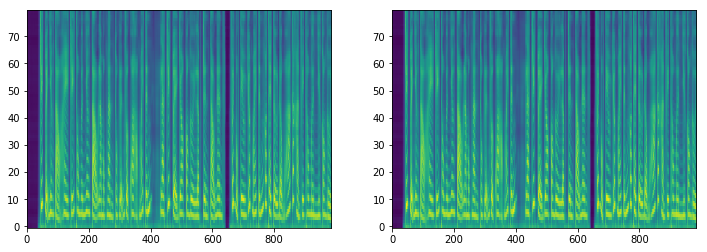

In [20]:
plot_data([mel.numpy(), mel_postnet.numpy()])

#### Synthesize audio from spectrogram using WaveGlow

In [21]:
# with torch.no_grad():
#     audio = waveglow.infer(mel, sigma=0.666)
# ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)
# waveglow.inference.inference(mel_postnet_torch, wave_glow, os.path.join(
#         "results", "short.wav"))
with torch.no_grad():
    audio = waveglow.infer(mel_postnet_torch, sigma=0.666)
    audio = audio * 32768.0
audio = audio.squeeze()
audio = audio.cpu().numpy()
audio = audio.astype('int16')
write("short.wav", 22050, audio)

#### (Optional) Remove WaveGlow bias

In [57]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

AttributeError: 'numpy.ndarray' object has no attribute 'cuda'

In [58]:
audio_save = audio_denoised.cpu().numpy()
librosa.output.write_wav('audio.wav', audio_save.T, hparams.sampling_rate)
# write('audio.wav', 22050, audio_save)

NameError: name 'audio_denoised' is not defined

In [ ]:
import librosa

# audio = pts("câu gì đó, gì đó. câu gì đó nữa, câu gì đó, gì gì đó. chả biết viết câu gì đó nữa, tóm lại là câu gì đó")
# audio = pts("toàn bộ việc nâng cấp các hạng mục nói trên sẽ bắt đầu được thực hiện từ tháng sáu năm hai ngàn mười tám , sau khi có sự đồng thuận của chủ nhân các căn hộ , bằng chi phí của công ty cổ phần vinhomes với tổng ngân sách khoảng năm trăm tỷ đồng .")
# audio = pts("xin chào , tôi tên là hoàng phúc . tôi đã tốt nghiệp . hiện tại , tôi đang đi làm .")
audio = pts("xin chào , tôi tên là hoàng phúc. tôi đã tốt nghiệp. bây giờ, tôi đang đi làm ở hồ chí minh")
librosa.output.write_wav('audio_long.wav', audio.T, hparams.sampling_rate)
# write('audio_long.wav', 22050, audio)